In [1]:
%pip install httpx
%pip install pandas
%pip install scipy
%pip install matplotlib
%pip install tables
%pip install xgboost
%pip install scikit-learn

You should consider upgrading via the '/Users/alexander/Projects/senso-rehab/imu-gesture-recognition-notebook/.venv/bin/python -m pip install --upgrade pip' command.


Note: you may need to restart the kernel to use updated packages.
You should consider upgrading via the '/Users/alexander/Projects/senso-rehab/imu-gesture-recognition-notebook/.venv/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
You should consider upgrading via the '/Users/alexander/Projects/senso-rehab/imu-gesture-recognition-notebook/.venv/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
You should consider upgrading via the '/Users/alexander/Projects/senso-rehab/imu-gesture-recognition-notebook/.venv/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
You should consider upgrading via the '/Users/alexander/Projects/senso-rehab/imu-gesture-recognition-notebook/.venv/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
You sh

In [1]:
import io
import math

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot
import matplotlib.lines as mlines
from scipy.spatial import transform as scipy_transform

# Helpers

In [2]:
import os

import httpx


class Clickhouse:
    credentials = {
        "user": os.environ['CLICKHOUSE_USER'],
        "password": os.environ['CLICKHOUSE_PASSWORD'],
    }
    url = os.environ['CLICKHOUSE_URL']

    def __init__(self):
        self._httpx_client = httpx.Client()

    def post(
        self,
        query: str,
        headers: dict = None,
        content: bytes = None,
    ) -> str:
        response = self._httpx_client.post(
            url=self.url,
            params={
                "query": query,
                **self.credentials,
            },
            headers=headers,
            content=content,
        )
        return response.text

    def get(
        self,
        query: str,
        headers: dict = None,
    ) -> str:
        response = self._httpx_client.get(
            url=self.url,
            params={
                "query": query,
                **self.credentials,
            },
            headers=headers,
        )
        return response.text


# Load Data

In [3]:
df = None
try:
    df = pd.read_hdf('./data/dataset_gross_prod.h5')
except FileNotFoundError:
    pass

In [4]:
if df is None:
    ch = Clickhouse()
    pos_csv_str = ch.get('SELECT * FROM raw_data FORMAT CSV')
    print(pos_csv_str[:200])

In [5]:
if df is None:
    df = pd.read_csv(
        io.StringIO(pos_csv_str),
        names=[
            'game_result_id', 'game_id', 'patient_id', 'exercise_id', 'timestamp', 'src', 
            'side', 'h_rssi', 'h_gain', 'g_rssi', 'g_gain', 'forearm_quat_x',
            'forearm_quat_y', 'forearm_quat_z', 'forearm_quat_w', 'forearm_lia_x',
            'forearm_lia_y', 'forearm_lia_z', 'forearm_grv_x', 'forearm_grv_y',
            'forearm_grv_z', 'forearm_tilt', 'shoulder_quat_x', 'shoulder_quat_y',
            'shoulder_quat_z', 'shoulder_quat_w', 'shoulder_lia_x',
            'shoulder_lia_y', 'shoulder_lia_z', 'shoulder_grv_x', 'shoulder_grv_y',
            'shoulder_grv_z', 'shoulder_tilt', 'position_type'
        ],
    )
    df.to_hdf('./data/dataset_gross_prod.h5', key='df', mode='w')

In [6]:
df['patient_id'].unique()

array([245, 618, 552, 588, 377, 594, 612, 614, 231])

In [7]:
game_results_patient_1 = df[df['patient_id'] == 612]['game_result_id'].unique()
game_results_patient_1


array([13622, 13624, 13371, 13373, 13625, 13387, 13627, 13389, 13391,
       13504, 13505, 13506, 13507])

In [8]:
game_results_patient_2 = df[df['patient_id'] == 614]['game_result_id'].unique()
game_results_patient_2

array([13630, 13631, 13632, 13393, 13633, 13394, 13395, 13396, 13397,
       13513, 13514, 13515])

In [9]:
df.loc[df['game_result_id'].isin([13391, 13625, 13393, 13633])].to_hdf('./data/sample_gross_dataset.h5', key='df', mode='w')
df.loc[df['game_result_id'].isin([13391, 13625, 13393, 13633])].to_csv('./data/sample_gross_dataset.csv', mode='w')

# Discover data

In [10]:
df.head(5)

,game_result_id,game_id,patient_id,exercise_id,timestamp,src,side,h_rssi,h_gain,g_rssi,...,shoulder_quat_z,shoulder_quat_w,shoulder_lia_x,shoulder_lia_y,shoulder_lia_z,shoulder_grv_x,shoulder_grv_y,shoulder_grv_z,shoulder_tilt,position_type
0,13601,12,245,7,1997-07-18 12:20:34,00:00:00:00:00:00,1,-99,0,0,...,-0.228246,0.070393,-0.014,0.017,0.018,-6.997,-5.258,-4.470,0.191756,0
1,13601,12,245,7,1997-07-18 12:20:50,00:00:00:00:00:00,1,-99,0,0,...,-0.227818,0.070692,-0.062,0.030,0.024,-7.035,-5.219,-4.470,0.191148,0
2,13601,12,245,7,1997-07-18 12:21:06,00:00:00:00:00:00,1,-99,0,0,...,-0.227661,0.070765,-0.042,0.027,0.038,-7.035,-5.239,-4.479,0.191218,0
3,13601,12,245,7,1997-07-18 12:21:23,00:00:00:00:00:00,1,-99,0,0,...,-0.227546,0.070798,-0.077,0.003,0.052,-7.058,-5.209,-4.508,0.191276,0
4,13601,12,245,7,1997-07-18 12:21:40,00:00:00:00:00:00,1,-99,0,0,...,-0.227546,0.070815,0.046,-0.028,0.084,-6.997,-5.317,-4.546,0.191220,0


In [11]:
df.describe()

,game_result_id,game_id,patient_id,exercise_id,side,h_rssi,h_gain,g_rssi,g_gain,forearm_quat_x,...,shoulder_quat_z,shoulder_quat_w,shoulder_lia_x,shoulder_lia_y,shoulder_lia_z,shoulder_grv_x,shoulder_grv_y,shoulder_grv_z,shoulder_tilt,position_type
count,863299.000000,863299.000000,863299.000000,863299.000000,863299.000000,863299.000000,863299.0,863299.0,863299.0,863299.000000,...,863299.000000,863299.000000,863299.000000,863299.000000,863299.000000,863299.000000,863299.000000,863299.000000,863299.000000,863299.000000
mean,13442.891714,12.175150,517.238543,7.429206,1.404151,-28.875167,0.0,0.0,0.0,0.616545,...,0.018149,0.214336,-0.036779,0.008903,0.016551,-5.371928,-4.540476,-4.403008,0.213721,0.005067
std,134.858963,1.093332,136.433902,0.494963,0.490727,44.998540,0.0,0.0,0.0,0.270717,...,0.309927,0.575343,0.355576,0.366457,0.461615,2.916112,2.786076,3.451149,0.403846,0.091539
min,13237.000000,12.000000,231.000000,7.000000,1.000000,-99.000000,0.0,0.0,0.0,0.000000,...,-0.729122,-0.999874,-12.082000,-12.135000,-13.864000,-20.421000,-19.924000,-18.114000,-0.746533,0.000000
25%,13318.000000,12.000000,377.000000,7.000000,1.000000,-99.000000,0.0,0.0,0.0,0.433823,...,-0.144654,-0.164004,-0.153000,-0.119000,-0.069000,-7.488000,-6.619000,-7.782000,0.000000,0.000000
50%,13461.000000,12.000000,588.000000,7.000000,1.000000,0.000000,0.0,0.0,0.0,0.678424,...,0.048455,0.352448,-0.027000,0.006000,0.007000,-6.426000,-5.147000,-3.917000,0.000000,0.000000
75%,13576.000000,12.000000,614.000000,8.000000,2.000000,0.000000,0.0,0.0,0.0,0.832759,...,0.248513,0.724787,0.084000,0.132000,0.098000,-3.109000,-2.853000,-1.760000,0.228439,0.000000
max,13633.000000,19.000000,618.000000,8.000000,2.000000,0.000000,0.0,0.0,0.0,0.999725,...,0.675516,0.999365,9.048000,18.333000,14.091000,10.376000,11.318000,11.348000,1.570251,2.000000


In [12]:
print(f"{len(df['patient_id'].unique())} patients, {len(df['game_result_id'].unique())} game results")

9 patients, 85 game results


# Calc angle features

In [13]:
def calc_ang_to_Y(row):
    w, x, y, z = row.to_list()
    rotation = scipy_transform.Rotation.from_quat([x, y, z, w])
    vec = rotation.apply([0, 1, 0])
    rad_angle = np.arcsin(vec[2])
    deg_angle = math.degrees(rad_angle)
    return -deg_angle

In [14]:
forearm_quat = [
    'forearm_quat_x', 
    'forearm_quat_y', 
    'forearm_quat_z', 
    'forearm_quat_w',
]
df['forearm_y_ang'] = df[forearm_quat].apply(calc_ang_to_Y, axis=1)
df['forearm_y_ang'].head(5)

0   -27.104250
1   -27.170934
2   -27.175137
3   -27.175137
4   -27.178614
Name: forearm_y_ang, dtype: float64

<AxesSubplot: >

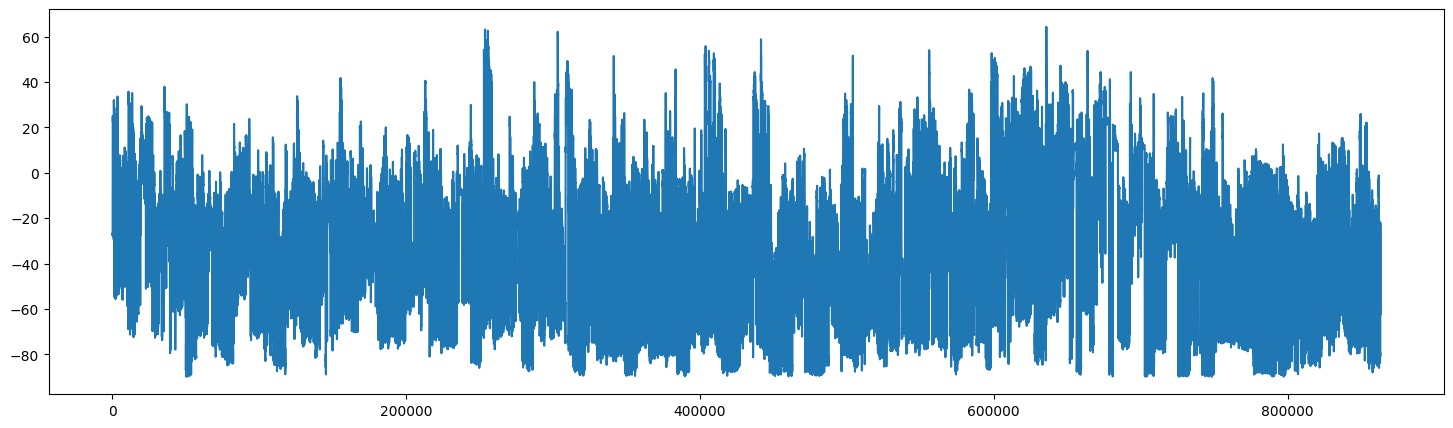

In [15]:
df['forearm_y_ang'].plot(figsize=(18, 5))

In [16]:
shoulder_quat = [
    'shoulder_quat_x',
    'shoulder_quat_y',
    'shoulder_quat_z',
    'shoulder_quat_w',
]
df['shoulder_y_ang'] = df[shoulder_quat].apply(calc_ang_to_Y, axis=1)
df['shoulder_y_ang'].head(5)

0   -10.986856
1   -10.951979
2   -10.955979
3   -10.959384
4   -10.956140
Name: shoulder_y_ang, dtype: float64

<AxesSubplot: >

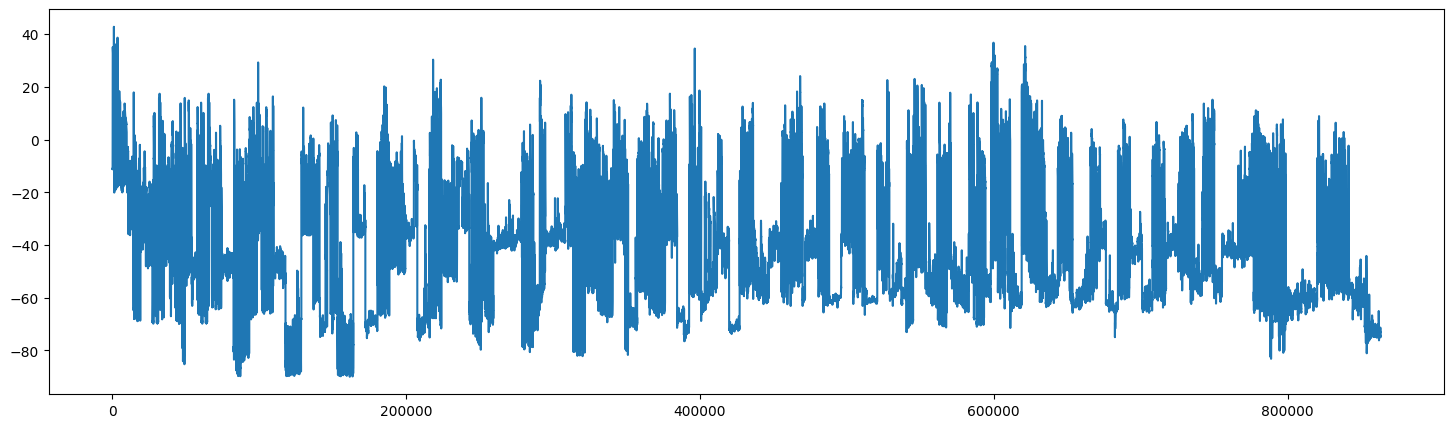

In [17]:
df['shoulder_y_ang'].plot(figsize=(18, 5))

In [18]:
def calc_forearm_shoulder_ang(row):    
    forearm_rotation = scipy_transform.Rotation.from_quat(row.to_list()[:4])
    shoulder_rotation = scipy_transform.Rotation.from_quat(row.to_list()[4:])
    forearm_vec = forearm_rotation.apply([0, 1, 0])
    shoulder_vec = shoulder_rotation.apply([0, 1, 0])
    dot_product = np.dot(forearm_vec / np.linalg.norm(forearm_vec),
                         shoulder_vec / np.linalg.norm(shoulder_vec))
    rad_angle = np.arccos(dot_product)
    deg_angle = math.degrees(rad_angle)
    return deg_angle

In [19]:
forearm_shoulder_quats = [
    'forearm_quat_x', 
    'forearm_quat_y', 
    'forearm_quat_z', 
    'forearm_quat_w',
    'shoulder_quat_x', 
    'shoulder_quat_y', 
    'shoulder_quat_z', 
    'shoulder_quat_w',
]
df['forearm_shoulder_ang'] = df[forearm_shoulder_quats].apply(
    calc_forearm_shoulder_ang, 
    axis=1
)
df['forearm_shoulder_ang'].head(5)

0    15.963966
1    15.967931
2    15.962383
3    15.956629
4    15.953317
Name: forearm_shoulder_ang, dtype: float64

<AxesSubplot: >

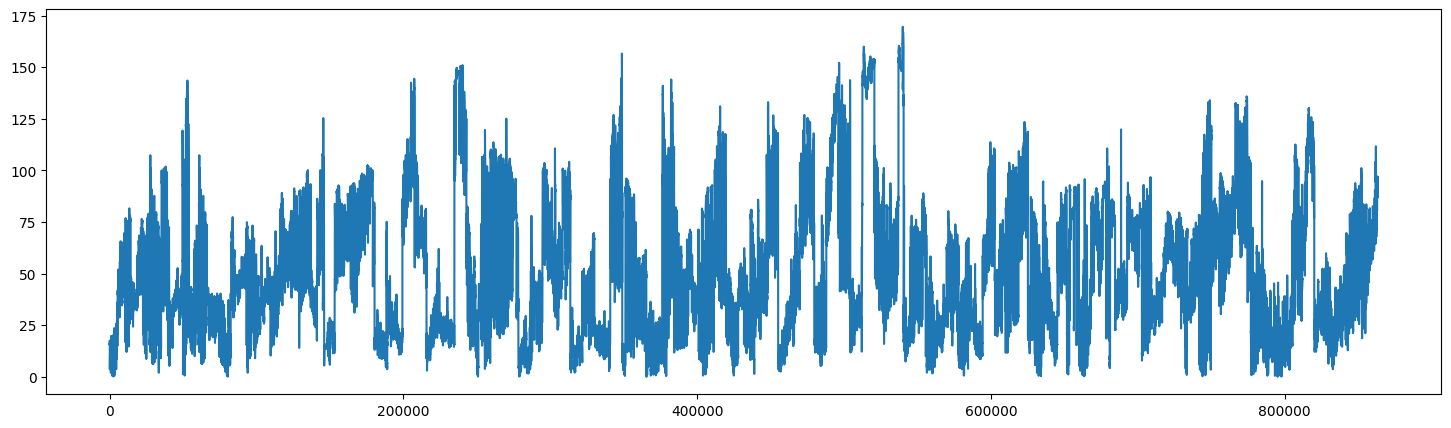

In [20]:
df['forearm_shoulder_ang'].plot(figsize=(18, 5))

# Calc lia features

<AxesSubplot: >

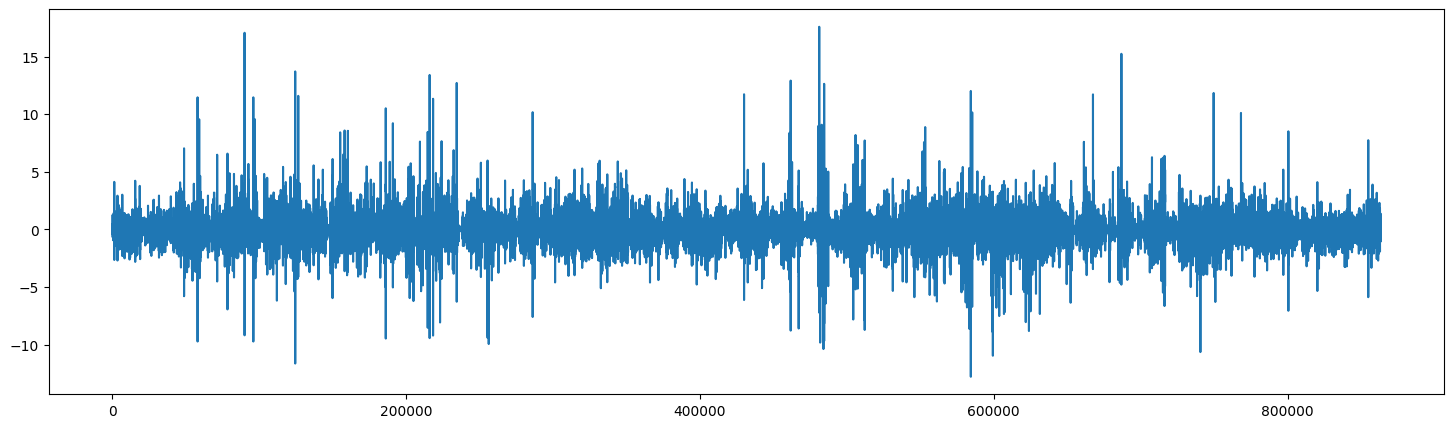

In [21]:
df['forearm_lia_x'] = df['forearm_lia_x'][abs(df['forearm_lia_x']) < 25]
df['forearm_lia_x'].plot(figsize=(18, 5))

<AxesSubplot: >

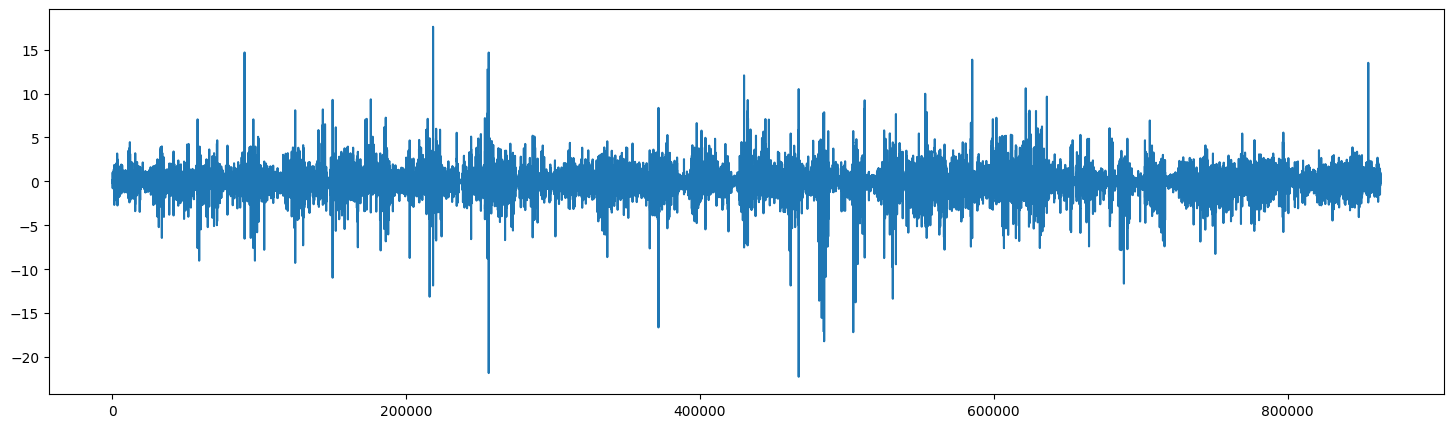

In [22]:
df['forearm_lia_y'] = df['forearm_lia_y'][abs(df['forearm_lia_y']) < 25]
df['forearm_lia_y'].plot(figsize=(18, 5))

<AxesSubplot: >

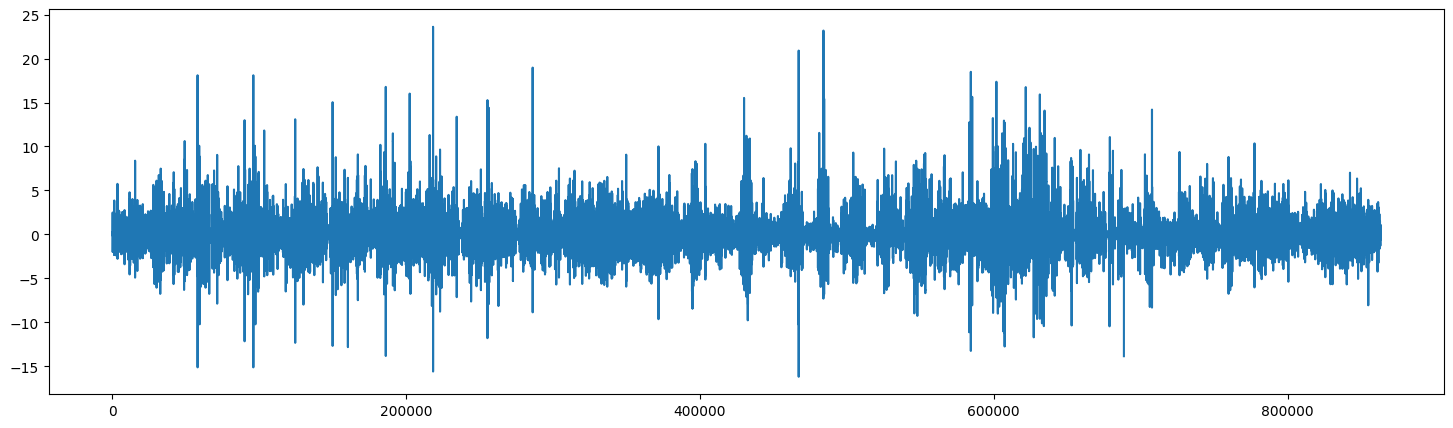

In [23]:
df['forearm_lia_z'] = df['forearm_lia_z'][abs(df['forearm_lia_z']) < 25]
df['forearm_lia_z'].plot(figsize=(18, 5))

<AxesSubplot: >

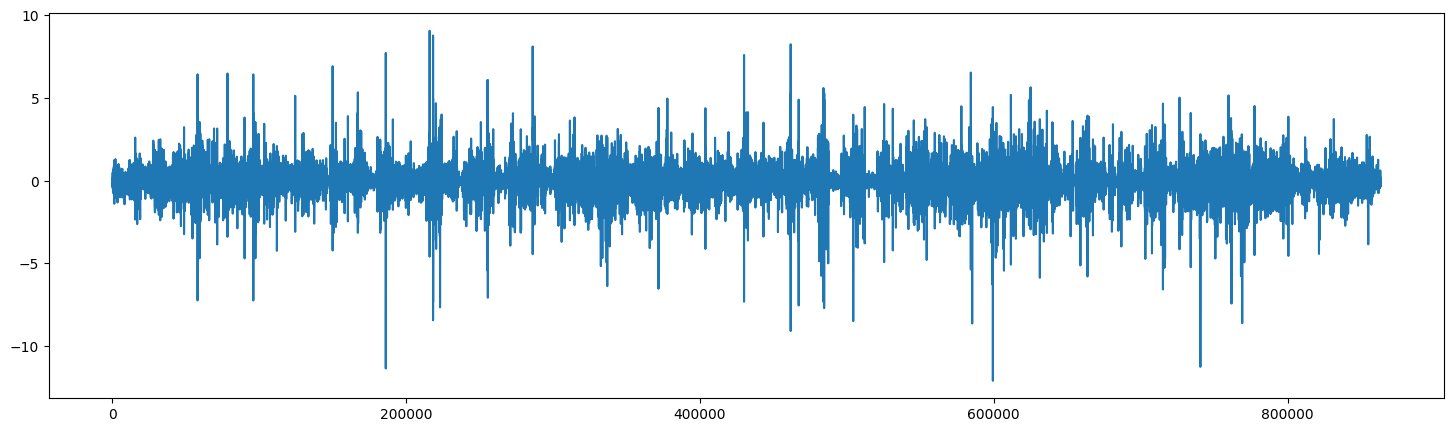

In [24]:
df['shoulder_lia_x'] = df['shoulder_lia_x'][abs(df['shoulder_lia_x']) < 25]
df['shoulder_lia_x'].plot(figsize=(18, 5))

<AxesSubplot: >

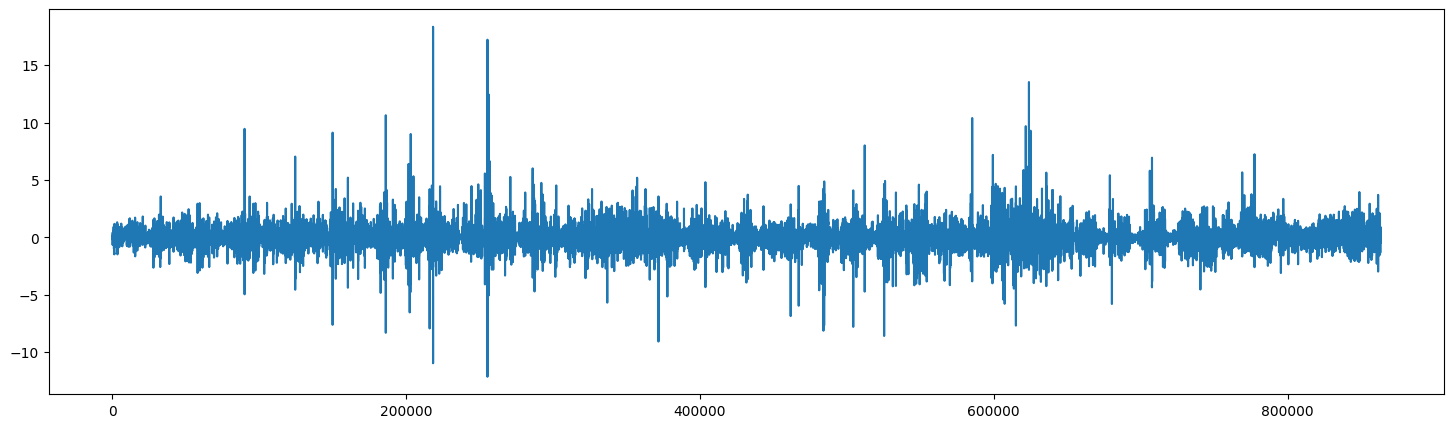

In [25]:
df['shoulder_lia_y'] = df['shoulder_lia_y'][abs(df['shoulder_lia_y']) < 25]
df['shoulder_lia_y'].plot(figsize=(18, 5))

<AxesSubplot: >

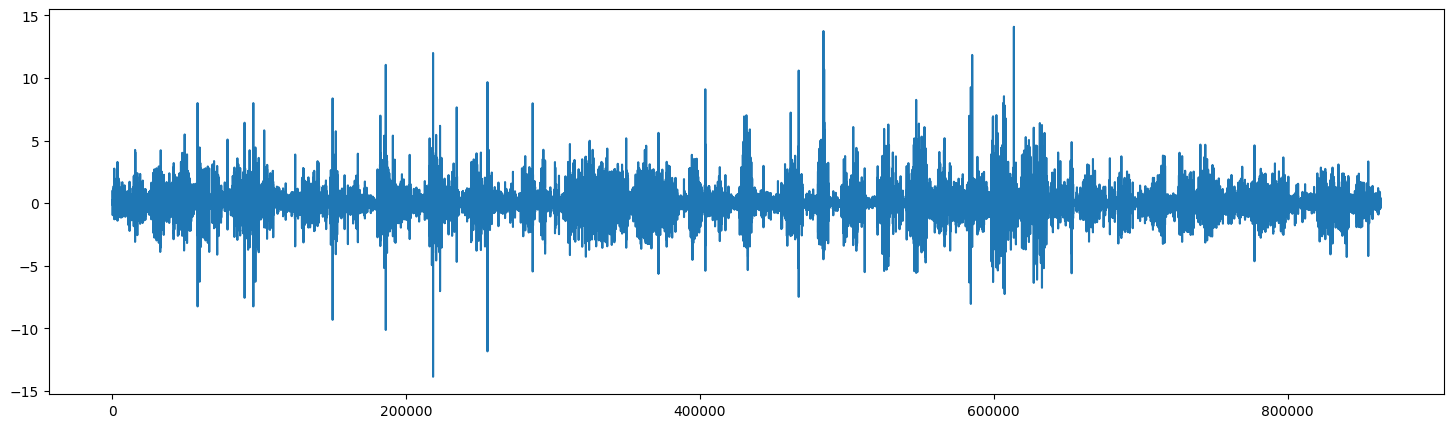

In [26]:
df['shoulder_lia_z'] = df['shoulder_lia_z'][abs(df['shoulder_lia_z']) < 25]
df['shoulder_lia_z'].plot(figsize=(18, 5))

# Discover game sessions

In [27]:
def plot_game_result(result_id, frame_range=(0, -1), save=False, positionType = None, new_figure=True):
    defprops = {
        'xdata': [],
        'ydata': [],
        'linestyle': 'None',
        'markersize': 10
    }
    black_arrow = mlines.Line2D(
        **defprops,
        marker='^',
        color='black',
        label='start position',
    )
    red_arrow = mlines.Line2D(
        **defprops,
        marker='v',
        color='red',
        label='end position',
    )
    plt.legend(handles=[black_arrow, red_arrow])

    result_df = df.loc[df['game_result_id'] == result_id].reset_index(drop=True)
    result_df = result_df.iloc[frame_range[0]:frame_range[1]]

    assert len(exercise_ids := result_df['exercise_id'].unique()) == 1
    assert len(patient_ids := result_df['patient_id'].unique()) == 1
    assert len(game_ids := result_df['game_id'].unique()) == 1
    exercise_id = exercise_ids[0]
    patient_id = patient_ids[0]
    game_id = game_ids[0]

    # positionType = 1, labled by 'ArrowDown'. A hand in lower position.
    start_mark_locs = result_df.loc[result_df['position_type'] == 1].index
    # positionType = 2, labled by 'ArrowUp'. A hand in upper position.
    end_mark_locs = result_df.loc[result_df['position_type'] == 2].index    
    
    if frame_range:
        start_mark_locs = [i - frame_range[0] for i in start_mark_locs]
        end_mark_locs = [i - frame_range[0] for i in end_mark_locs]

    result_df['forearm_y_ang'].plot(
        title=f'patient {patient_id}, result {result_id}, exercise {exercise_id}, game {game_id}',
        figsize=(25, 6),
        color='tab:blue',
        marker='^',
        markersize=10,
        markerfacecolor='black',
        markevery=start_mark_locs,
    )
    ax = result_df['forearm_y_ang'].plot(
        figsize=(25, 6),
        color='tab:blue',
        marker='v',
        markersize=10,
        markerfacecolor='red',
        markevery=end_mark_locs,
    )
    if save:
        fig = ax.get_figure()
        path = (
            (f'./charts/p{patient_id}_r{result_id}_e{exercise_id}') +
            (f'_{frame_range[0]}_{frame_range[1]}' if frame_range != (0, -1) else '') + 
            (f'_{positionType}' if positionType else '')
        )
        fig.savefig(path, facecolor='#FFFFFF') 
    if new_figure:
        plt.figure()


In [28]:
def plot_game_sessions(patient_id, save=False):
    patient_df = df.loc[df['patient_id'] == patient_id]
    result_ids = patient_df['game_result_id'].unique()
    print(result_ids)
    for result_id in result_ids:
        plot_game_result(result_id, save=save)

In [29]:
PATIENT_IDS = sorted(df['patient_id'].unique())
PATIENT_IDS

[231, 245, 377, 552, 588, 594, 612, 614, 618]

In [30]:
GAME_RESULT_IDS = sorted(df['game_result_id'].unique())
GAME_RESULT_IDS

[13237,
 13238,
 13239,
 13240,
 13241,
 13242,
 13243,
 13244,
 13245,
 13246,
 13247,
 13248,
 13249,
 13253,
 13254,
 13270,
 13273,
 13276,
 13278,
 13280,
 13282,
 13289,
 13318,
 13319,
 13320,
 13325,
 13371,
 13373,
 13387,
 13389,
 13391,
 13393,
 13394,
 13395,
 13396,
 13397,
 13439,
 13440,
 13441,
 13442,
 13458,
 13459,
 13460,
 13461,
 13475,
 13477,
 13478,
 13479,
 13486,
 13487,
 13495,
 13496,
 13497,
 13498,
 13504,
 13505,
 13506,
 13507,
 13513,
 13514,
 13515,
 13562,
 13563,
 13575,
 13576,
 13577,
 13578,
 13586,
 13589,
 13590,
 13591,
 13601,
 13604,
 13612,
 13613,
 13614,
 13615,
 13622,
 13624,
 13625,
 13627,
 13630,
 13631,
 13632,
 13633]

[13270]


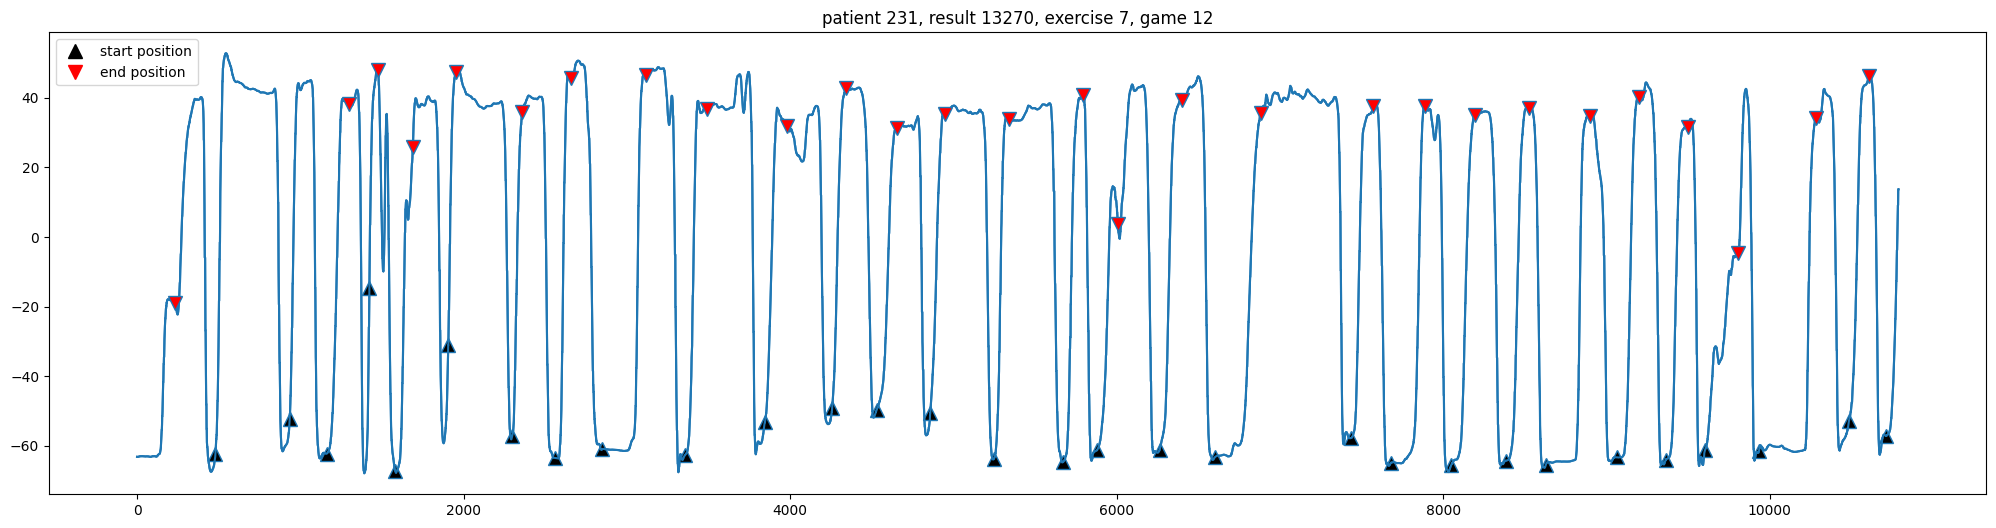

<Figure size 640x480 with 0 Axes>

In [31]:
# Others game sessions looks similar 
for patient_id in PATIENT_IDS[:1]:
    plot_game_sessions(patient_id)

# Hypothesis 1
The model will work precicely, if it will have rolling windows based features that capture the "corner" of amplitude change or zone includes both sharp change of a sensor's angle to the Y axis, then moment where the angle stops to change sharply and then relatively flat zone. 

In [32]:
def get_mark_locs(studied_result_id):
    result_df = df.loc[df['game_result_id'] == studied_result_id].reset_index(drop=True)
    # 'ArrowDown' positionType = 1;
    start_mark_locs = result_df.loc[result_df['position_type'] == 1].index
    # 'ArrowUp' positionType = 2;
    end_mark_locs = result_df.loc[result_df['position_type'] == 2].index   
    return start_mark_locs, end_mark_locs  

In [33]:
def plot_samples(result_id):
    start_mark_locs, end_mark_locs = get_mark_locs(result_id)
    plt.figure()
    for mark_loc in start_mark_locs:
        frame_range = (max(0, mark_loc - 55), mark_loc + 15)
        plot_game_result(result_id, frame_range, save=True, positionType='start', new_figure=False)
    plt.figure()
    for mark_loc in end_mark_locs:
        frame_range = (max(0, mark_loc - 55), mark_loc + 15)
        plot_game_result(result_id, frame_range, save=True, positionType='end', new_figure=False)

## Windows size detection

In [34]:
studied_patient_id = PATIENT_IDS[4]
studied_patient_id

588

In [35]:
result_ids = df.loc[df['patient_id'] == studied_patient_id]['game_result_id'].unique()
result_ids

array([13237, 13238, 13239, 13240, 13241, 13242, 13439, 13440, 13441,
       13442, 13562, 13563])

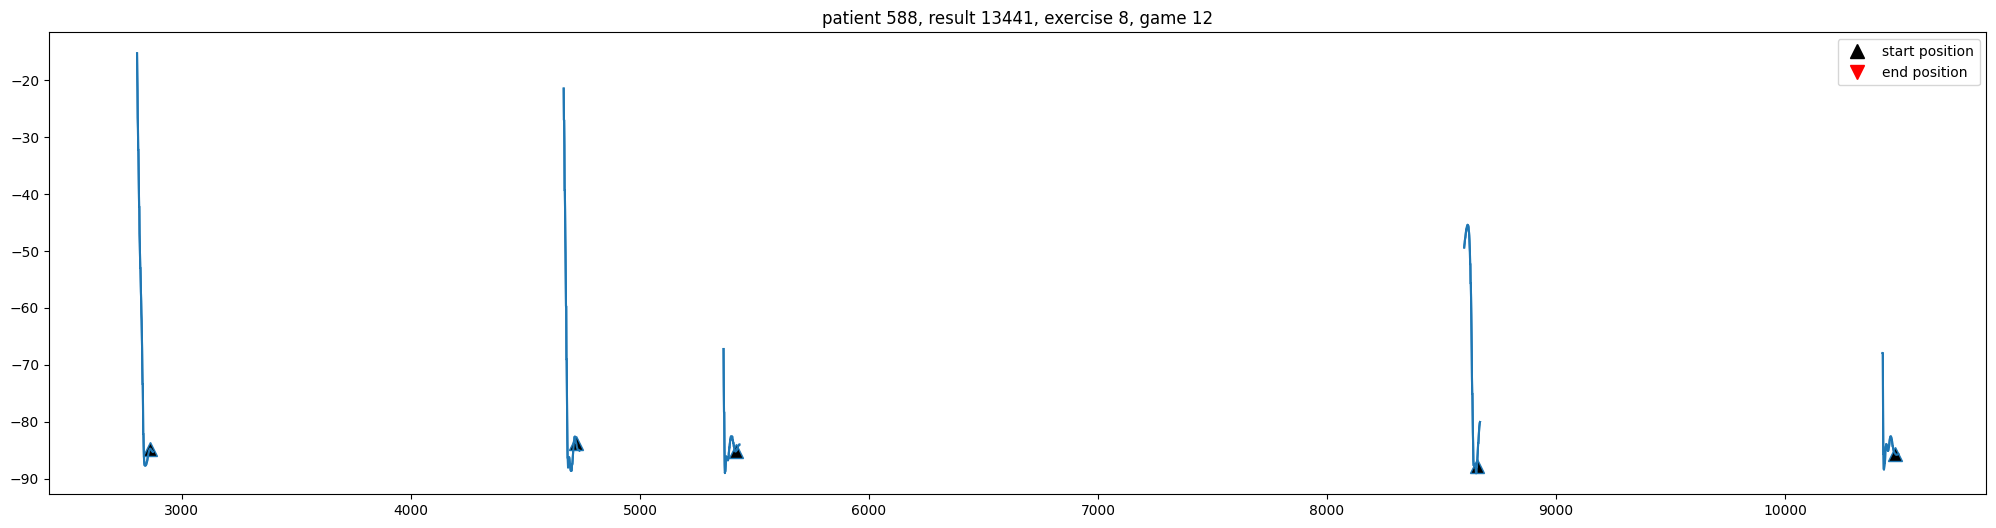

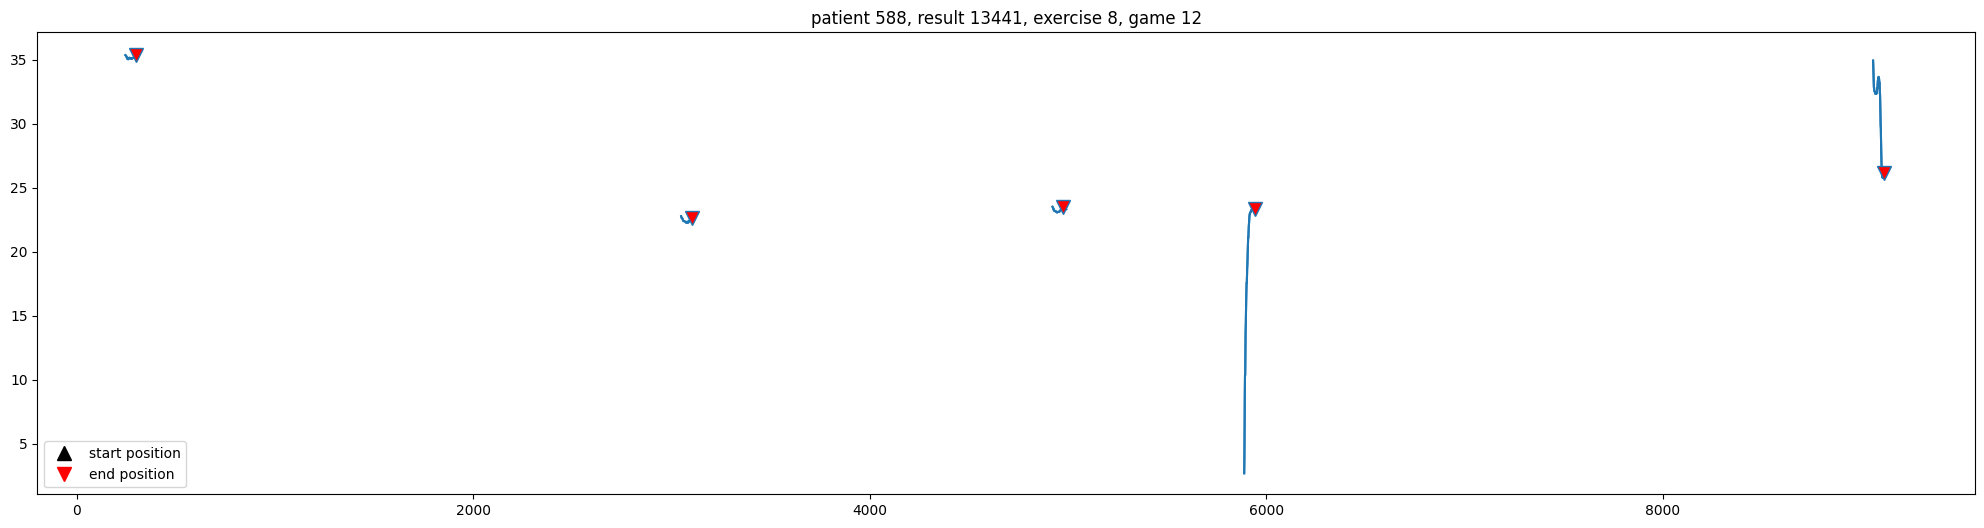

In [36]:
plot_samples(result_ids[8])

In [37]:
OPTIMAL_WINDOW_SIZE = 70

## Data labeling
Optimal window size is 70

In [38]:
def mark_ranges():    
    df['position_type_window'] = 0

    # 'ArrowDown' positionType = 1;
    start_mark_locs = df.loc[df['position_type'] == 1].index
    # 'ArrowUp' positionType = 2;
    end_mark_locs = df.loc[df['position_type'] == 2].index   

    for mark_loc in start_mark_locs:
        df.loc[max(mark_loc - 55, 0): mark_loc + 15, 'position_type_window'] = 1
    for mark_loc in end_mark_locs:
        df.loc[max(mark_loc - 55, 0): mark_loc + 15, 'position_type_window'] = 2


In [39]:
mark_ranges()
df['position_type_window'].head(5)

0    0
1    0
2    0
3    0
4    0
Name: position_type_window, dtype: int64

In [40]:
def plot_mark_ranges(result_id):
    result_df = df.loc[df['game_result_id'] == result_id].reset_index(drop=True)
    # result_df = result_df.iloc[0:2500]

    patient_ids = result_df['patient_id'].unique()
    assert len(patient_ids) == 1
    patient_id = patient_ids[0]
    
    # 'ArrowDown' positionType = 1;
    start_mark_locs = result_df.loc[result_df['position_type_window'] == 1].index
    # 'ArrowUp' positionType = 2;
    end_mark_locs = result_df.loc[result_df['position_type_window'] == 2].index  

    result_df['forearm_y_ang'].plot(
        title=f'patient {patient_id}, result {result_id}',
        figsize=(25, 6),
        color='tab:blue',
        marker='o',
        markeredgewidth=0,
        markersize=5,
        markerfacecolor='black',
        markevery=start_mark_locs,
    )
    result_df['forearm_y_ang'].plot(
        figsize=(25, 6),
        color='tab:blue',
        marker='o',
        markeredgewidth=0,
        markersize=5,
        markerfacecolor='red',
        markevery=end_mark_locs,
    )
    plt.figure()


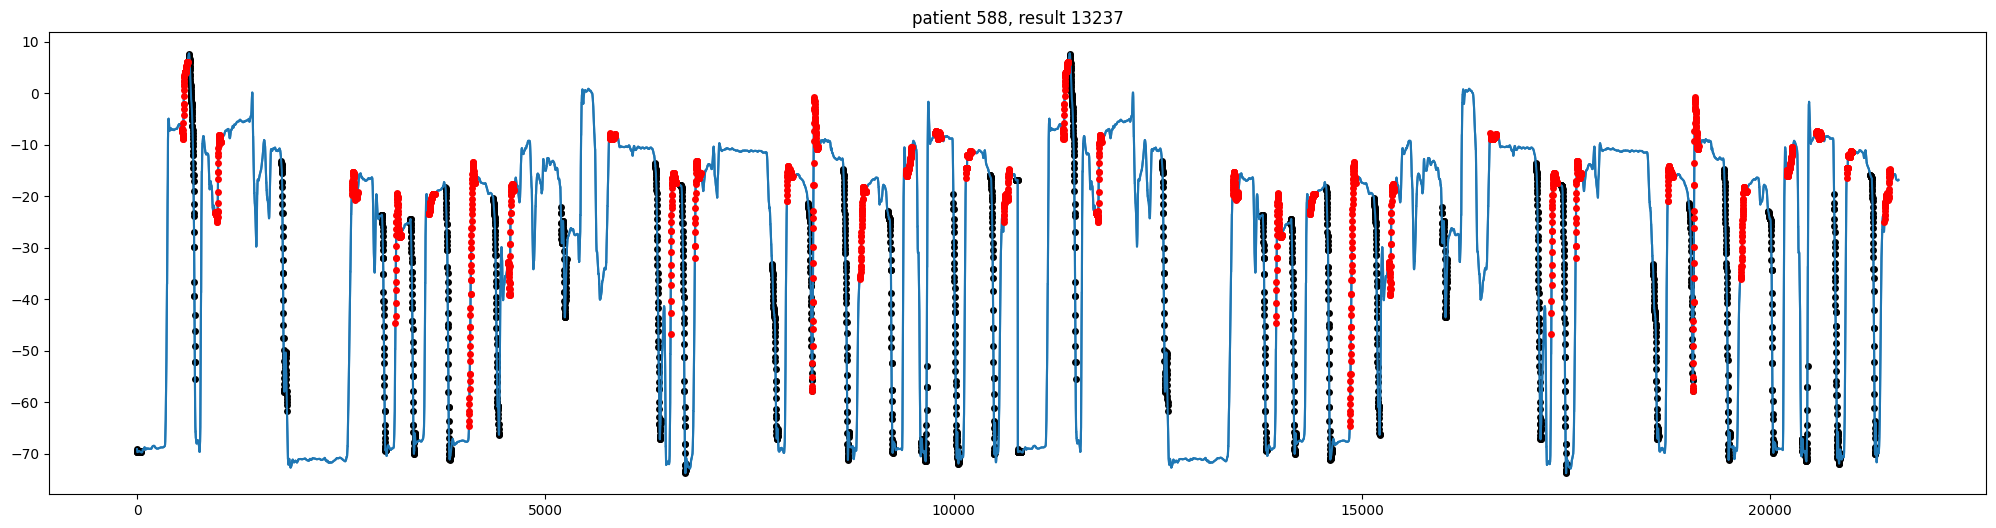

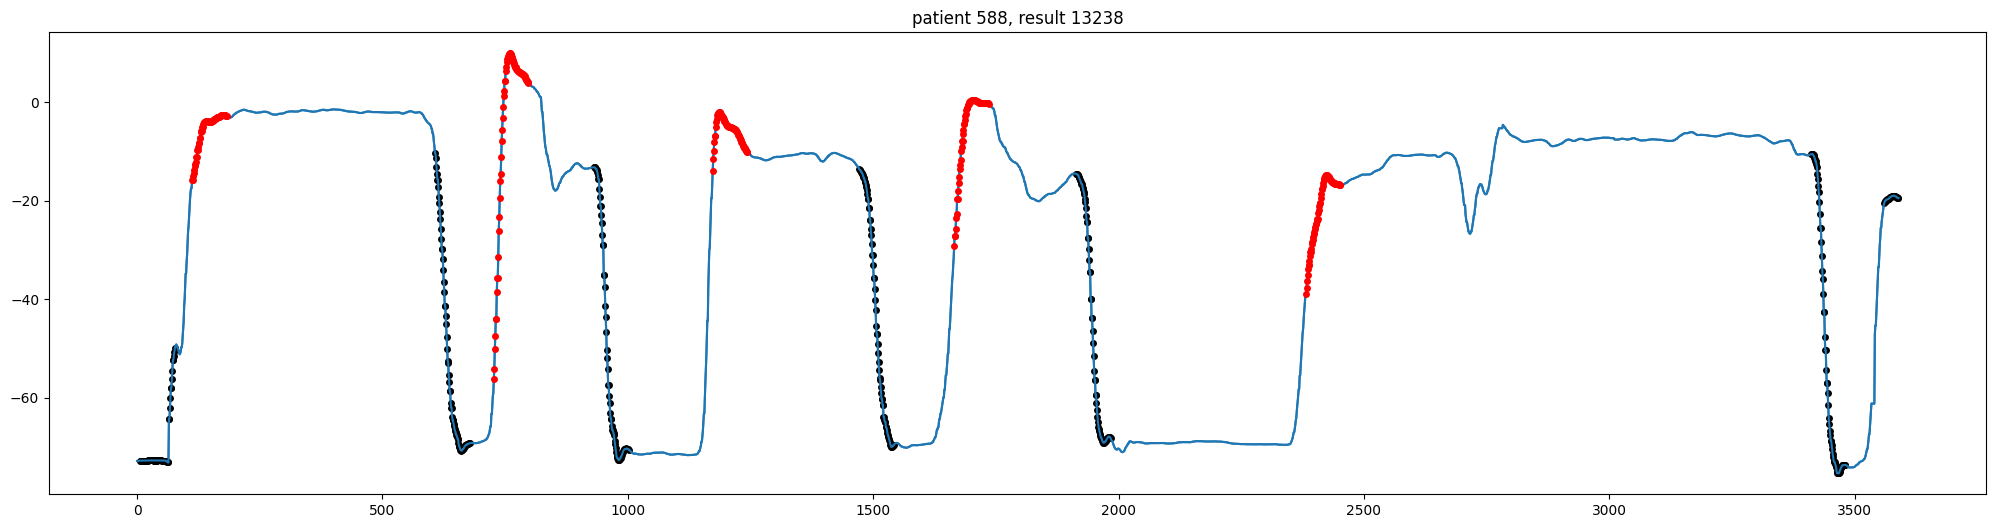

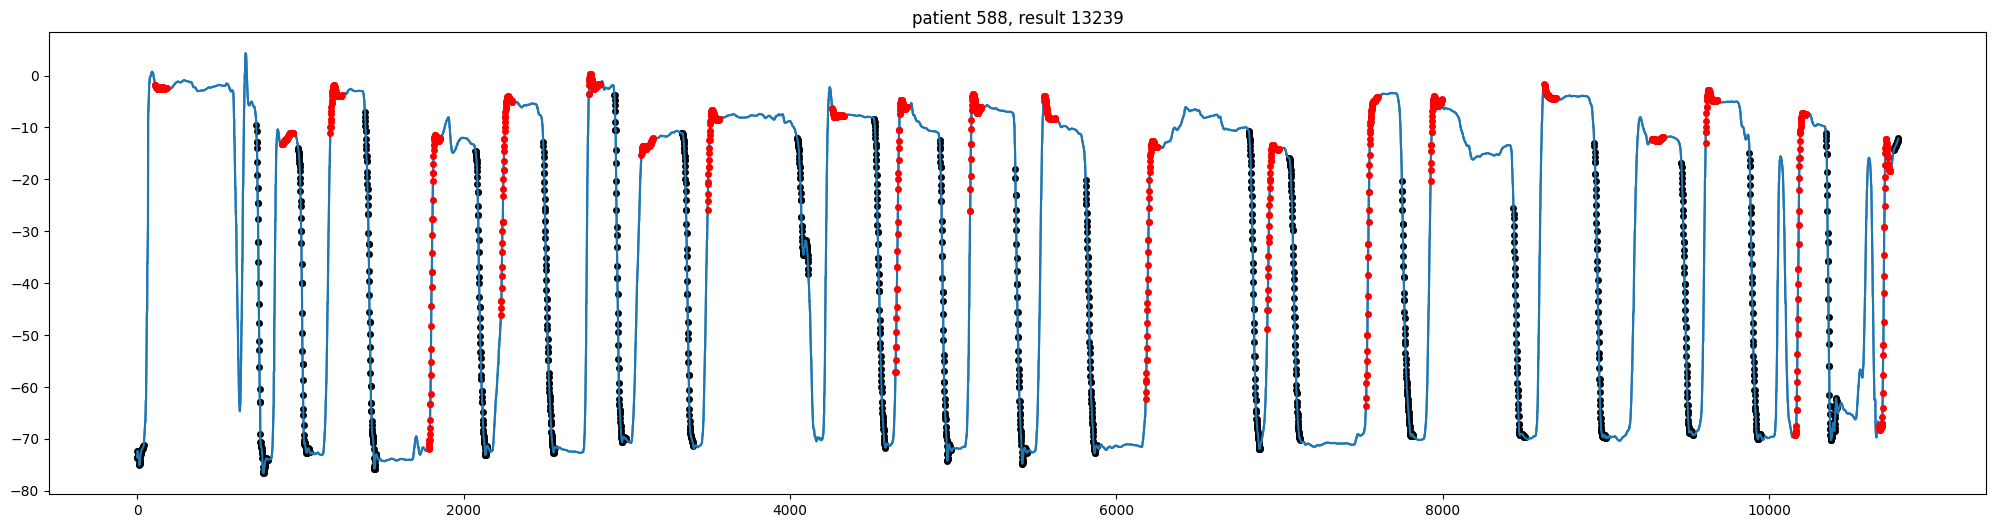

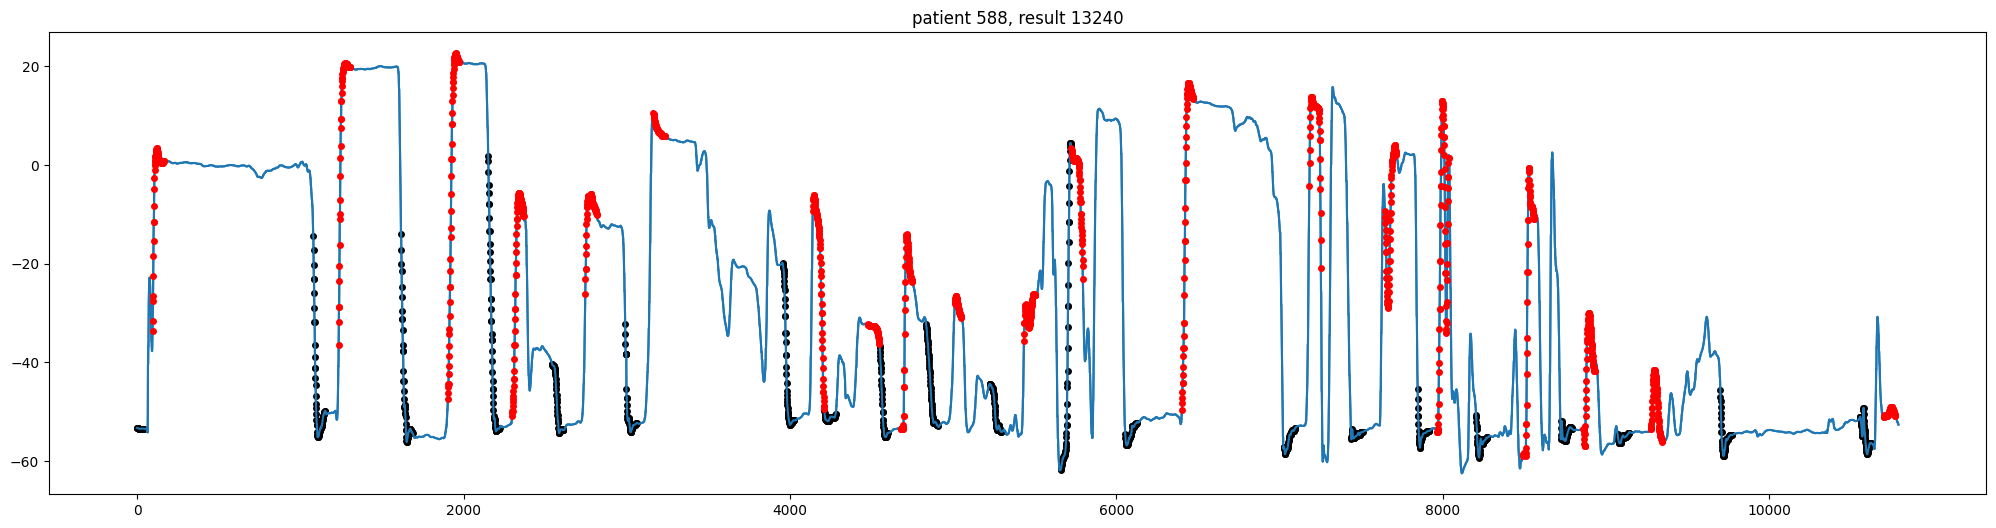

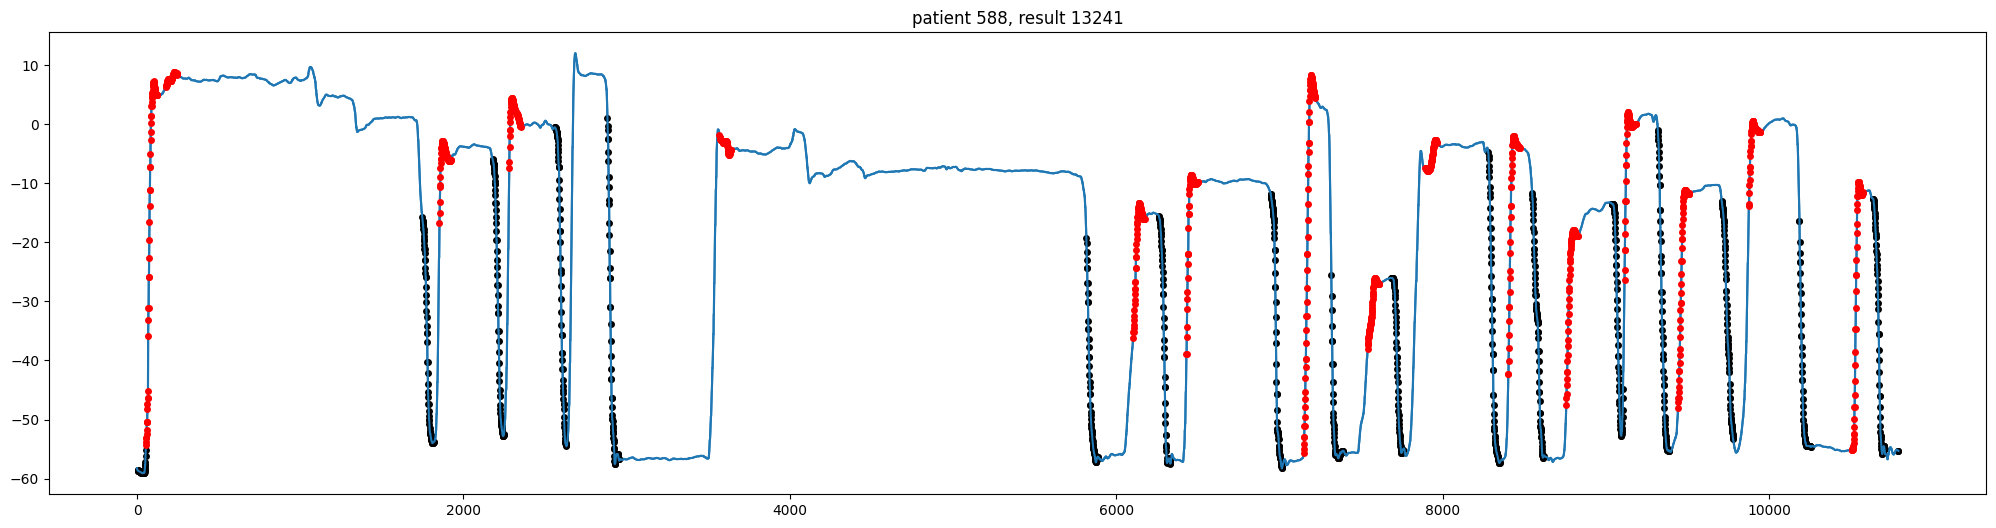

<Figure size 640x480 with 0 Axes>

In [41]:
for result_id in GAME_RESULT_IDS[:5]:
    plot_mark_ranges(result_id)

## Feature Extration

**Discrete:**
- ~~Угол между 2-мя датчиками~~
- ~~Разность между текущим углом и углом между сенсорами в предыдущем распознанном исходном положении~~
- ~~Разность между текущим и средним углом между сенсорами~~

**Window based:**
- ~~forearm_y_ang_rolling_10_mean~~
- ~~forearm_shoulder_ang_rolling_10_mean~~
- ~~forearm_y_ang_rolling_130_std~~
- ~~forearm_shoulder_ang_rolling_130_std~~
- ~~forearm_y_ang_rolling_100_min~~
- ~~forearm_y_ang_rolling_100_max~~
- ~~forearm_y_ang_rolling_20_diff_curr_max~~
- ~~forearm_y_ang_rolling_20_diff_curr_min~~
- ~~forearm_y_ang_mean_rolling_130_diff_max_rolling_130~~
- ~~forearm_y_ang_mean_rolling_130_diff_min_rolling_130~~
- ~~forearm_y_ang_median_rolling_130~~
----------------------------------------------------------------------------
- Фичи волатильноти сигнала
- Количество переходов через 0 угловой скорости (смена знака скорости означает смену направления движения руки) за N предшествующих фреймов
- Количество и частота пиков угла между датчиками за N предшествующих фреймов



In [42]:
import random

def plot_feature(name):
    plot_num = 10
    start_range = random.randint(0, len(GAME_RESULT_IDS) - plot_num)
    end_range = plot_num + start_range 
    for result_id in GAME_RESULT_IDS[start_range:end_range]:
        result_df = df.loc[df['game_result_id'] == result_id].reset_index(drop=True)
        # result_df = result_df.iloc[0:2500]

        patient_ids = result_df['patient_id'].unique()
        assert len(patient_ids) == 1
        patient_id = patient_ids[0]
        
        # 'ArrowDown' positionType = 1;
        start_mark_locs = result_df.loc[result_df['position_type_window'] == 1].index
        # 'ArrowUp' positionType = 2;
        end_mark_locs = result_df.loc[result_df['position_type_window'] == 2].index  

        result_df[name].plot(
            title=f'feature: {name}, patient: {patient_id}, result: {result_id}',
            figsize=(25, 6),
            color='tab:blue',
            marker='o',
            markeredgewidth=0,
            markersize=5,
            markerfacecolor='black',
            markevery=start_mark_locs,
        )
        result_df[name].plot(
            figsize=(25, 6),
            color='tab:blue',
            marker='o',
            markeredgewidth=0,
            markersize=5,
            markerfacecolor='red',
            markevery=end_mark_locs,
        )
        plt.figure()


### forearm_y_ang_rolling_10_mean

In [43]:
df['forearm_y_ang_rolling_10_mean'] = df['forearm_y_ang'].rolling(10).mean()

In [44]:
# plot_feature('forearm_y_ang_rolling_10_mean')

### shoulder_y_ang_rolling_10_mean

In [45]:
df['shoulder_y_ang_rolling_10_mean'] = df['shoulder_y_ang'].rolling(10).mean()

In [46]:
# plot_feature('shoulder_y_ang_rolling_10_mean')

### forearm_shoulder_ang_rolling_10_mean

In [47]:
df['forearm_shoulder_ang_rolling_10_mean'] = df['forearm_shoulder_ang'].rolling(10).mean()

In [48]:
# plot_feature('forearm_shoulder_ang_rolling_10_mean')

### forearm_direction

In [49]:
df['forearm_direction'] = df['forearm_y_ang_rolling_10_mean'] - df['forearm_y_ang_rolling_10_mean'].shift(1)
# plot_feature('forearm_direction')

### shoulder_direction

In [50]:
df['shoulder_direction'] = df['shoulder_y_ang_rolling_10_mean'] - df['shoulder_y_ang_rolling_10_mean'].shift(1)
# plot_feature('shoulder_direction')

### forearm_shoulder_direction

In [51]:
df['forearm_shoulder_direction'] = df['forearm_shoulder_ang_rolling_10_mean'] - df['forearm_shoulder_ang_rolling_10_mean'].shift(1)
# plot_feature('forearm_shoulder_direction')

### forearm_y_ang_rolling_130_std_directed

In [52]:
df['forearm_y_ang_rolling_130_std_directed'] = df['forearm_y_ang'].rolling(130).std() * np.sign(df['forearm_direction'])
# plot_feature('forearm_y_ang_rolling_130_std_directed')

### shoulder_y_ang_rolling_130_std

In [53]:
df['shoulder_y_ang_rolling_130_std_directed'] = df['shoulder_y_ang'].rolling(130).std() * np.sign(df['shoulder_direction'])

In [54]:
# plot_feature('shoulder_y_ang_rolling_130_std_directed')

### forearm_shoulder_ang_rolling_130_std_directed

In [55]:
df['forearm_shoulder_ang_rolling_130_std_directed'] = df['forearm_shoulder_ang'].rolling(130).std() * np.sign(df['forearm_shoulder_direction'])

In [56]:
# plot_feature('forearm_shoulder_ang_rolling_130_std_directed')

### forearm_y_ang_rolling_100_min

In [57]:
df['forearm_y_ang_rolling_100_min'] = df['forearm_y_ang'].rolling(100).min()

In [58]:
# plot_feature('forearm_y_ang_rolling_100_min')

### forearm_shoulder_ang_rolling_100_min

In [59]:
df['forearm_shoulder_ang_rolling_100_min'] = df['forearm_shoulder_ang'].rolling(100).min()

In [60]:
# plot_feature('forearm_shoulder_ang_rolling_100_min')

### shoulder_y_ang_rolling_100_min

In [61]:
df['shoulder_y_ang_rolling_100_min'] = df['shoulder_y_ang'].rolling(100).min()

In [62]:
# plot_feature('shoulder_y_ang_rolling_100_min')

### forearm_y_ang_rolling_100_max

In [63]:
df['forearm_y_ang_rolling_100_max'] = df['forearm_y_ang'].rolling(100).max()

In [64]:
# plot_feature('forearm_y_ang_rolling_100_max')

### shoulder_y_ang_rolling_100_max

In [65]:
df['shoulder_y_ang_rolling_100_max'] = df['shoulder_y_ang'].rolling(100).max()

In [66]:
# plot_feature('shoulder_y_ang_rolling_100_max')

### forearm_shoulder_ang_rolling_100_max

In [67]:
df['forearm_shoulder_ang_rolling_100_max'] = df['forearm_shoulder_ang'].rolling(100).max()

In [68]:
# plot_feature('forearm_shoulder_ang_rolling_100_max')

### forearm_y_ang_rolling_20_diff_curr_max

In [69]:
df['forearm_y_ang_rolling_20_diff_curr_max'] = df['forearm_y_ang'] - df['forearm_y_ang'].rolling(20).max()

In [70]:
# plot_feature('forearm_y_ang_rolling_20_diff_curr_max')

### shoulder_y_ang_rolling_20_diff_curr_max

In [71]:
df['shoulder_y_ang_rolling_20_diff_curr_max'] = df['shoulder_y_ang'] - df['shoulder_y_ang'].rolling(20).max()

In [72]:
# plot_feature('shoulder_y_ang_rolling_20_diff_curr_max')

### forearm_shoulder_ang_rolling_20_diff_curr_max

In [73]:
df['forearm_shoulder_ang_rolling_20_diff_curr_max'] = df['forearm_shoulder_ang'] - df['forearm_shoulder_ang'].rolling(20).max()

In [74]:
# plot_feature('forearm_shoulder_ang_rolling_20_diff_curr_max')

### forearm_y_ang_rolling_20_diff_curr_min

In [75]:
df['forearm_y_ang_rolling_20_diff_curr_min'] = df['forearm_y_ang'] - df['forearm_y_ang'].rolling(20).min()

In [76]:
# plot_feature('forearm_y_ang_rolling_20_diff_curr_min')

### shoulder_y_ang_rolling_20_diff_curr_min

In [77]:
df['shoulder_y_ang_rolling_20_diff_curr_min'] = df['shoulder_y_ang'] - df['shoulder_y_ang'].rolling(20).min()
# plot_feature('shoulder_y_ang_rolling_20_diff_curr_min')

### forearm_shoulder_ang_rolling_20_diff_curr_min

In [78]:
df['forearm_shoulder_ang_rolling_20_diff_curr_min'] = df['forearm_shoulder_ang'] - df['forearm_shoulder_ang'].rolling(20).min()
# plot_feature('forearm_shoulder_ang_rolling_20_diff_curr_min')

### forearm_y_ang_diff_max_rolling_100_min_rolling_10

In [79]:
df['forearm_y_ang_diff_max_rolling_100_min_rolling_10'] = df['forearm_y_ang'].rolling(100).max() - df['forearm_y_ang'].rolling(10).min()
# plot_feature('forearm_y_ang_diff_max_rolling_100_min_rolling_10')

### forearm_y_ang_diff_min_rolling_100_max_rolling_10

In [80]:
df['forearm_y_ang_diff_min_rolling_100_max_rolling_10'] = df['forearm_y_ang'].rolling(100).max() - df['forearm_y_ang'].rolling(10).min()
# plot_feature('forearm_y_ang_diff_min_rolling_100_max_rolling_10')

### forearm_y_ang_mean_rolling_130_diff_min_rolling_130

In [81]:
df['forearm_y_ang_mean_rolling_130_diff_min_rolling_130'] = df['forearm_y_ang'].rolling(130).mean() - df['forearm_y_ang'].rolling(130).min()
# plot_feature('forearm_y_ang_mean_rolling_130_diff_min_rolling_130')

### forearm_y_ang_mean_rolling_130_diff_max_rolling_130

In [82]:
df['forearm_y_ang_mean_rolling_130_diff_max_rolling_130'] = df['forearm_y_ang'].rolling(130).mean() - df['forearm_y_ang'].rolling(130).max()
# plot_feature('forearm_y_ang_mean_rolling_130_diff_max_rolling_130')

### forearm_y_ang_median_rolling_130

In [83]:
df['forearm_y_ang_median_rolling_130'] = df['forearm_y_ang'].rolling(130).median()
# plot_feature('forearm_y_ang_median_rolling_130')

### shoulder_y_ang_median_rolling_130

In [84]:
df['shoulder_y_ang_median_rolling_130'] = df['shoulder_y_ang'].rolling(130).median()
# plot_feature('shoulder_y_ang_median_rolling_130')

### forearm_lia_x_mean_rolling_130

In [85]:
df['forearm_lia_x_mean_rolling_130'] = df['forearm_lia_x'].rolling(130).mean()
# plot_feature('forearm_lia_x_mean_rolling_130')

### shoulder_lia_x_mean_rolling_130

In [86]:
df['shoulder_lia_x_mean_rolling_130'] = df['forearm_lia_x'].rolling(130).mean()
# plot_feature('shoulder_lia_x_mean_rolling_130')

### forearm_lia_y_mean_rolling_130

In [87]:
df['forearm_lia_y_mean_rolling_130'] = df['forearm_lia_y'].rolling(130).mean()
# plot_feature('forearm_lia_y_mean_rolling_130')

### shoulder_lia_y_mean_rolling_130

In [88]:
df['shoulder_lia_y_mean_rolling_130'] = df['forearm_lia_y'].rolling(130).mean()
# plot_feature('shoulder_lia_y_mean_rolling_130')

### forearm_lia_z_mean_rolling_130

In [89]:
df['forearm_lia_z_mean_rolling_130'] = df['forearm_lia_z'].rolling(130).mean()
# plot_feature('forearm_lia_z_mean_rolling_130')

### shoulder_lia_z_mean_rolling_130

In [90]:
df['shoulder_lia_z_mean_rolling_130'] = df['forearm_lia_z'].rolling(130).mean()
# plot_feature('shoulder_lia_z_mean_rolling_130')

### forearm_lia_x_median_rolling_130

In [91]:
df['forearm_lia_x_median_rolling_130'] = df['forearm_lia_x'].rolling(130).median()
# plot_feature('forearm_lia_x_median_rolling_130')

### forearm_lia_y_median_rolling_30

In [92]:
df['forearm_lia_y_median_rolling_30'] = df['forearm_lia_y'].rolling(30).median()
# plot_feature('forearm_lia_y_median_rolling_30')

### forearm_lia_z_median_rolling_130

In [93]:
df['forearm_lia_z_median_rolling_130'] = df['forearm_lia_z'].rolling(130).median()
# plot_feature('forearm_lia_z_median_rolling_130')

### forearm_y_ang_curr_diff_shift_10

In [94]:
df['forearm_y_ang_curr_diff_shift_10'] = df['forearm_y_ang'] - df['forearm_y_ang'].shift(10)
# plot_feature('forearm_y_ang_curr_diff_shift_10')

### shoulder_y_ang_curr_diff_shift_10

In [95]:
df['shoulder_y_ang_curr_diff_shift_10'] = df['shoulder_y_ang'] - df['shoulder_y_ang'].shift(10)
# plot_feature('shoulder_y_ang_curr_diff_shift_10')

### forearm_shoulder_ang_curr_diff_shift_10

In [96]:
df['forearm_shoulder_ang_curr_diff_shift_10'] = df['forearm_shoulder_ang'] - df['forearm_shoulder_ang'].shift(10)
# plot_feature('forearm_shoulder_ang_curr_diff_shift_10')

### forearm_y_ang_mean_rolling_130_diff_max_rolling_130_std_rolling_30

In [97]:
df['forearm_y_ang_mean_rolling_130_diff_max_rolling_130_std_rolling_30'] = df['forearm_y_ang_mean_rolling_130_diff_max_rolling_130'].rolling(30).std()
# plot_feature('forearm_y_ang_mean_rolling_130_diff_max_rolling_130_std_rolling_30')

### forearm_y_ang_mean_rolling_130_diff_min_rolling_130_std_rolling_30

In [98]:
df['forearm_y_ang_mean_rolling_130_diff_min_rolling_130_std_rolling_30'] = df['forearm_y_ang_mean_rolling_130_diff_min_rolling_130'].rolling(30).std()
# plot_feature('forearm_y_ang_mean_rolling_130_diff_min_rolling_130_std_rolling_30')

## Model selection

### XGBoost

In [99]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


In [100]:
EXCLUDE_CLOS = [
    'position_type_window', 
    'position_type', 
    'timestamp', 
    'src', 
    'forearm_tilt', 
    'shoulder_tilt',
    'side',
    'patient_id',
    'game_id',
    'game_result_id',
]

X_columns = list(filter(lambda x: x not in EXCLUDE_CLOS, df.columns)) 
X_columns

['exercise_id',
 'h_rssi',
 'h_gain',
 'g_rssi',
 'g_gain',
 'forearm_quat_x',
 'forearm_quat_y',
 'forearm_quat_z',
 'forearm_quat_w',
 'forearm_lia_x',
 'forearm_lia_y',
 'forearm_lia_z',
 'forearm_grv_x',
 'forearm_grv_y',
 'forearm_grv_z',
 'shoulder_quat_x',
 'shoulder_quat_y',
 'shoulder_quat_z',
 'shoulder_quat_w',
 'shoulder_lia_x',
 'shoulder_lia_y',
 'shoulder_lia_z',
 'shoulder_grv_x',
 'shoulder_grv_y',
 'shoulder_grv_z',
 'forearm_y_ang',
 'shoulder_y_ang',
 'forearm_shoulder_ang',
 'forearm_y_ang_rolling_10_mean',
 'shoulder_y_ang_rolling_10_mean',
 'forearm_shoulder_ang_rolling_10_mean',
 'forearm_direction',
 'shoulder_direction',
 'forearm_shoulder_direction',
 'forearm_y_ang_rolling_130_std_directed',
 'shoulder_y_ang_rolling_130_std_directed',
 'forearm_shoulder_ang_rolling_130_std_directed',
 'forearm_y_ang_rolling_100_min',
 'forearm_shoulder_ang_rolling_100_min',
 'shoulder_y_ang_rolling_100_min',
 'forearm_y_ang_rolling_100_max',
 'shoulder_y_ang_rolling_100_max'

In [101]:
len(GAME_RESULT_IDS)

85

In [102]:
count_type = lambda x: len(df.loc[df['position_type_window'] == x])
count_type(0), count_type(1), count_type(2)

(655987, 105001, 102311)

In [123]:
X = df[X_columns]
y = df['position_type_window']
X_small = df.loc[df['game_result_id'].isin(GAME_RESULT_IDS[:10]), X_columns]
y_small = df.loc[df['game_result_id'].isin(GAME_RESULT_IDS[:10]), 'position_type_window']

In [104]:
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import cross_val_score

N_SPLITS = 4
gkfold = GroupKFold(n_splits=N_SPLITS)
model = XGBClassifier(n_estimators=100, max_depth=10, learning_rate=0.1, nthread=12)
result = cross_val_score(model, X, y, cv=gkfold, groups=df['game_result_id'], n_jobs=N_SPLITS)
print("Accuracy: %.2f%% (%.2f%%)" % (result.mean()*100, result.std()*100))

KeyboardInterrupt: 

### Random Forest

In [105]:
X.isna().sum()

exercise_id                                                             0
h_rssi                                                                  0
h_gain                                                                  0
g_rssi                                                                  0
g_gain                                                                  0
                                                                     ... 
forearm_y_ang_curr_diff_shift_10                                       10
shoulder_y_ang_curr_diff_shift_10                                      10
forearm_shoulder_ang_curr_diff_shift_10                                10
forearm_y_ang_mean_rolling_130_diff_max_rolling_130_std_rolling_30    158
forearm_y_ang_mean_rolling_130_diff_min_rolling_130_std_rolling_30    158
Length: 69, dtype: int64

In [124]:
X = X.fillna(0)
X_small = X_small.fillna(0)
assert not X.isna().any().any() 
assert not X_small.isna().any().any() 

In [127]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

gkfold = GroupKFold(n_splits=N_SPLITS)
gscv = GridSearchCV(
    estimator=RandomForestClassifier(),
    param_grid={
        'max_depth': [6, 8, 10],
        'n_estimators': [50, 100]
    },
    cv=gkfold,
    scoring='accuracy',
    n_jobs=-1,
)
gscv.fit(
    X_small, 
    y_small, 
    groups=df.loc[df['game_result_id'].isin(GAME_RESULT_IDS[:10]), 'game_result_id']
)
print(f"Accuracy: {gscv.best_score_:.2f} %, params: {gscv.best_params_}")

Accuracy: 0.83 %, params: {'max_depth': 10, 'n_estimators': 50}


In [128]:
from sklearn.model_selection import cross_val_score

gkfold = GroupKFold(n_splits=N_SPLITS)
model = RandomForestClassifier(n_estimators=50, max_depth=10, n_jobs=12)
result = cross_val_score(model, X, y, cv=gkfold, groups=df['game_result_id'], n_jobs=N_SPLITS)
print("Accuracy: %.2f%% (%.2f%%)" % (result.mean()*100, result.std()*100))

Accuracy: 85.72% (0.67%)


### Decision tree

In [116]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

gkfold = GroupKFold(n_splits=N_SPLITS)
gscv = GridSearchCV(
    estimator=DecisionTreeClassifier(),
    param_grid={
        'max_depth': [6, 8, 10],
    },
    cv=gkfold,
    scoring='accuracy',
    n_jobs=-1,
)
gscv.fit(X, y, groups=df['game_result_id'])
print(f"Accuracy: {gscv.best_score_:.2f} %, params: {gscv.best_params_}")

Accuracy: 0.84 %, params: {'max_depth': 8}


## Feature importance

In [ ]:
# from sklearn.model_selection import GroupShuffleSplit 
# from sklearn.metrics import accuracy_score

# df_impts = df[df['game_result_id'].isin(GAME_RESULT_IDS[:10])]

# splitter = GroupShuffleSplit(test_size=.30, n_splits=2, random_state = 7)
# split = splitter.split(df_impts, groups=df_impts['game_result_id'])
# train_inds, test_inds = next(split)

# train_X_impts = df.loc[train_inds, X_columns] 
# train_y_impts = df.loc[train_inds, 'position_type_window']
# test_X_impts = df.loc[test_inds, X_columns] 
# test_y_impts = df.loc[test_inds, 'position_type_window']

# impts_model = XGBClassifier(n_estimators=100, max_depth=10, learning_rate=0.1, nthread=-1)
# impts_model.fit(train_X_impts, train_y_impts)

# preds = impts_model.predict(test_X_impts)
# print("Accuracy: %.2f%%" % (accuracy_score(test_y_impts, preds) * 100.0))


In [ ]:
# from xgboost import plot_importance

# ax = plot_importance(impts_model, height=0.5, importance_type='cover')
# fig = ax.figure
# fig.set_size_inches(35, 18)
# pyplot.show()

In [ ]:
# sorted(impts_model.feature_importances_)

In [ ]:
# from sklearn.feature_selection import SelectFromModel

# # select features using threshold
# selection = SelectFromModel(impts_model, threshold=0.008, prefit=True)
# select_X_train = selection.transform(train_X_impts)
# # train model
# selection_model = XGBClassifier(n_estimators=100, max_depth=10, learning_rate=0.1, nthread=-1)
# selection_model.fit(select_X_train, train_y_impts)
# # eval model
# select_X_test = selection.transform(test_X_impts)
# predictions = selection_model.predict(select_X_test)
# accuracy = accuracy_score(test_y_impts, predictions)
# print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (0.008, select_X_train.shape[1], accuracy*100.0))

In [ ]:
# feature_idx = selection.get_support()
# impt_X_columns = [train_X_impts.columns[idx] for idx, is_impt in enumerate(feature_idx) if is_impt]

In [ ]:
# from sklearn.model_selection import GroupShuffleSplit 
# from sklearn.metrics import accuracy_score

# splitter = GroupShuffleSplit(test_size=.30, n_splits=2, random_state = 7)
# split = splitter.split(df, groups=df['game_result_id'])
# train_inds, test_inds = next(split)

# train_X_impts = df.loc[train_inds, impt_X_columns] 
# train_y_impts = df.loc[train_inds, 'position_type_window']
# test_X_impts = df.loc[test_inds, impt_X_columns] 
# test_y_impts = df.loc[test_inds, 'position_type_window']

# impts_model = XGBClassifier(n_estimators=100, max_depth=10, learning_rate=0.1, nthread=-1)
# impts_model.fit(train_X_impts, train_y_impts)

# preds = impts_model.predict(test_X_impts)
# print("Accuracy: %.2f%%" % (accuracy_score(test_y_impts, preds) * 100.0))

In [ ]:
# def plot_prediction(result_id, feature_name):
#     result_df = X_test.loc[df['game_result_id'] == result_id].reset_index(drop=True)

#     assert len(exercise_ids := result_df['exercise_id'].unique()) == 1
#     assert len(patient_ids := result_df['patient_id'].unique()) == 1
#     assert len(game_ids := result_df['game_id'].unique()) == 1
#     exercise_id = exercise_ids[0]
#     patient_id = patient_ids[0]
#     game_id = game_ids[0]

#     # 'ArrowDown' positionType = 1;
#     start_mark_locs = result_df.loc[result_df['pred'] == 1].index
#     # 'ArrowUp' positionType = 2;
#     end_mark_locs = result_df.loc[result_df['pred'] == 2].index    

#     result_df[feature_name].plot(
#         title=f'feature: {feature_name}, patient: {patient_id}, result: {result_id}',
#         figsize=(25, 6),
#         color='tab:blue',
#         marker='o',
#         markeredgewidth=0,
#         markersize=5,
#         markerfacecolor='black',
#         markevery=start_mark_locs,
#     )
#     result_df[feature_name].plot(
#         figsize=(25, 6),
#         color='tab:blue',
#         marker='o',
#         markeredgewidth=0,
#         markersize=5,
#         markerfacecolor='red',
#         markevery=end_mark_locs,
#     )
#     plt.figure()

In [147]:
# for result_id in sorted(test_result_ids):
#     plot_prediction(result_id,'forearm_y_ang')

In [148]:
# print(f"Accuracy {accuracy_score(y_test, y_pred) * 100}%")